## Brachistochrone Curve

For reference, c.f. [here](https://baike.baidu.com/item/%E6%9C%80%E9%80%9F%E9%99%8D%E7%BA%BF%E9%97%AE%E9%A2%98).

Another code for this problem (also in TensorFlow) can be found [herein](https://github.com/yimuw/Let-Tensor-Flow/blob/master/control/brachistochrone_curve.py).

For a trajectory $y(x)$ for $\forall x \in [0, 1]$, the action (loss), as the total time spent, is given by
\begin{equation}
  \mathcal{L}[y] = \int_{x_0}^{x_1} d x 
                   \frac{ \sqrt{ 1 + {y^{\prime}}^2 (x) } } { \sqrt{ 2 g \left( y_0 - y(x) \right) } },
\end{equation}
with boundary condition
$$ y(x_0) = y_0 \;, y(x_1) = y_1 , $$
where $g$ is the gravitational constant and $y_0 > y_1$.

Employ the [Monte-Carlo approximation](https://en.wikipedia.org/wiki/Monte_Carlo_integration#Overview). Explicitly, let $\{ x_i: i = 1, \ldots, N \} \sim \text{Uniform}(x_0, x_1)$, the action with boundary condition and penalty becomes
\begin{equation}
  \mathcal{L}[y] = \frac{x_1 - x_0}{N} \sum_{i=1}^{N}
                   \frac{ \sqrt{ 1 + {y^{\prime}}^2 (x_i) } }{ \sqrt{ 2 g \left( y_0 - y(x_i) \right) } }
                   + \frac{1}{2} \sum_{ x_b \in \{x_0, x_1\} } d(y(x_b)), 
\end{equation}
with some pre-defined distance $d$.

In [1]:
%matplotlib notebook

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from datetime import datetime
from collections import namedtuple
import random as rn
import os

# Global parameters
_SEED = 42
_EPSILON = 1e-8

# For reproducibility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(_SEED)
rn.seed(_SEED)
tf.set_random_seed(_SEED)

/Users/shuiruge/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def make_neural_network(x, hidden_layers, output_shape, name=None):
  """Implement the generic neural network with the dense linear output
  layer.
  Args:
    x: Tensor-like, as the input of the neural network. It's shape is
        of `[batch_size] + x_shape`.
    hidden_layers: List of objects of the classes in `tf.layers`.
    output_shape: List of integers.
  Returns:
    The output tensor of the neural network.
  """
  with tf.name_scope(name, 'NeuralNetwork', [x]):
    x = tf.convert_to_tensor(x)
    
    # Hidden layers
    hidden = x  # initialize.
    for layer in hidden_layers:
      hidden = layer(hidden)
    
    # Output layer
    flatten_hidden = tf.layers.flatten(hidden)
    output_size = sum(flatten(output_shape))
    output = tf.layers.dense(flatten_hidden, output_size)
    output = tf.reshape(output, [-1]+output_shape)

  return output


def flatten(nested_list):
    """Helper. (Recursively) flatten an arbitrarily nested list."""
    if nested_list == []:
        return nested_list
    if isinstance(nested_list[0], list):
        return flatten(nested_list[0]) + flatten(nested_list[1:])
    return nested_list[:1] + flatten(nested_list[1:])


def make_action(y_bulk, grad_y_bulk, y_start, x_volumn,
                g=9.8, epsilon=_EPSILON, name=None):
    """Implements the action in Monte-Carlo integral.
    
    The action is a Monte-Carlo integral IN THE BULK.
    
    Args:
      y: Tensor-like, with shape `[batch_size] + y_shape`.
      grad_y: Tensor-like, with shape `[batch_size] + y_shape`.
      y_start: Tensor-like, with shape `y_shape`.
      x_volumn: Scalar-like.
      g: Scalar-like, as the gravitational constant, optional.
      epsilon: Scalar-like, for numerical stability, optional.
    Returns:
      Scalar.
    """
    with tf.name_scope(name, 'Action',
            [y_bulk, grad_y_bulk, y_start, x_volumn]):
      y_bulk = tf.convert_to_tensor(y_bulk)
      grad_y_bulk = tf.convert_to_tensor(grad_y_bulk)
      y_start = tf.convert_to_tensor(y_start)
      # Add `batch_size`-dimension
      y_start = tf.expand_dims(y_start, axis=0)
      x_volumn = tf.convert_to_tensor(x_volumn)
    
      with tf.name_scope('DeltaHeight'):
        delta_y = y_start - y_bulk
        # Clip `delta_y` so as to keep it positive
        delta_y = tf.where(delta_y > 0.0, delta_y, tf.zeros_like(delta_y))
        
      with tf.name_scope('Lagrangian'):
        lagrangians = tf.truediv(
            tf.sqrt(1.0 + grad_y_bulk**2),
            tf.sqrt(2.0 * g * delta_y) + epsilon)

      action = x_volumn * tf.reduce_mean(lagrangians)
      return action


def make_boundary(y_boundary, target_y_boundary,
                  n=4, lambda_=1e+3, name=None):
  """Make the boundary term, vanishing of which makes the fitting of boundary.
  
  $ b(y, y_b) := \lambda * \norm{y - y_b}_n $
  
  Args:
    y_boundary: Tensor-like, with the shape `[n_boundary] + y_shape`, as the
        boundary given by the neural network, as the $y$.
    target_y_boundary: Tensor-like, with the shape `[n_boundary] + y_shape`,
        as the target boundary to fit, as the $y_b$.
    n: Positive integer, employ L-`n` norm.
    lambda: Positive float.
  Returns:
    Scalar.
  """
  with tf.name_scope(name, 'Boundary', [y_boundary, target_y_boundary]):
    y_boundary = tf.convert_to_tensor(y_boundary)
    target_y_boundary = tf.convert_to_tensor(target_y_boundary)
    # `delta` shall be vanishing
    delta = y_boundary - target_y_boundary
    boundary = lambda_ * l_n_norm(delta, n)
    return boundary


def l_n_norm(x, n, name=None):
  """L-`n` norm of tensor `x`."""
  with tf.name_scope(name, 'L{}_Norm'.format(n), [x]):
    x = tf.convert_to_tensor(x)
    norm = tf.reduce_mean(x**n)
    return norm


ResultOps = namedtuple('ResultOps',
    'loss, grad_y_bulk, y_bulk, y_boundary, action, boundary')


def make_loss(x_bulk, x_boundary, target_y_boundary, make_y,
              name=None):
  """Implements the loss.
  
  Args:
    x_bulk: Tensor-like, with shape `[batch_size] + x_shape`, as the
        non-boundary values of the input to the neural network.
    x_boundary: Tensor-like, with shape `[n_boundaries] + x_shape`, as
        the boundary values of the input to the neural network.
    target_y_boundary: Tensor-like, with the shape `[n_boundary] + y_shape`,
        as the target boundary to fit.
    make_y: Callable that maps `x` to the neural network output.
  Returns:
    Scalar.
  """
  with tf.name_scope(name, 'Loss',
        [x_bulk, x_boundary, target_y_boundary]):
    x_bulk = tf.convert_to_tensor(x_bulk)
    x_boundary = tf.convert_to_tensor(x_boundary)
    target_y_boundary = tf.convert_to_tensor(target_y_boundary)
    
    x = tf.concat([x_bulk, x_boundary], axis=0)
    y = make_y(x)

    batch_size = x_bulk.get_shape().as_list()[0]
    n_boundary = x_boundary.get_shape().as_list()[0]
    y_bulk, y_boundary = tf.split(y, [batch_size, n_boundary],
                                  axis=0)
    grad_y_bulk = tf.gradients(y_bulk, [x_bulk])[0]
    y_start = tf.unstack(target_y_boundary, axis=0)[0]
    
    x_start, x_end = tf.unstack(x_boundary, axis=0)
    x_volumn = tf.reduce_prod(x_end - x_start)

    action = make_action(y_bulk, grad_y_bulk, y_start, x_volumn)
    boundary = make_boundary(y_boundary, target_y_boundary)
    #loss = action * (1 + boundary)
    loss = action + boundary

  return ResultOps(loss, grad_y_bulk, y_bulk, y_boundary, action, boundary)

In [3]:
def generate_analytic_solution(A, max_theta):
    """Generates the analytic solution of brachistochrone curve.
    with parameters to be fine-tuned so as to match the boundary
    condtions."""
    theta = np.linspace(0, max_theta, 100, dtype='float32')
    theta = np.expand_dims(theta, axis=1)
    X = A * (theta - np.sin(theta))
    y = -A * (1.0 - np.cos(theta))
    return X, y


def l1_norm(x):
    """Helper. L1-norm."""
    return np.mean(np.abs(x))



def plot_frame(figure, subplot, X, y, message,
               X_analytic, y_analytic):
    """Helper, for dynamic plot."""
    subplot.clear()
    subplot.plot(X, y, X_analytic, y_analytic)
    subplot.set_title(message)
    figure.canvas.draw()


def test(x_dim=1, y_dim=1, x_boundary=[[0],[3]], target_y_boundary=[[0],[-1]],
         n_samples=1000, hidden_units_list=[10]*3, activation=tf.nn.sigmoid,
         optimizer=tf.train.AdamOptimizer(0.001), n_iters=10**4, skip_step=100,
         analytic_A=0.63, analytic_max_theta=4.15):
    
    # -- Analytic solution for comparison
    X_analytic, y_analytic = generate_analytic_solution(
            analytic_A, analytic_max_theta)

    # -- Build graph
    
    tf.reset_default_graph()

    x_bulk = tf.placeholder(shape=[n_samples, x_dim], dtype='float32',
                            name='x_bulk')
    x_boundary = np.array(x_boundary, dtype='float32')
    target_y_boundary = np.array(target_y_boundary, dtype='float32')

    hidden_layers = []
    for units in hidden_units_list:
        hidden_layers += [
            lambda x: tf.layers.dense(
                x, units, activation=activation),
        ]
            
    def make_y(x):
        return make_neural_network(x, hidden_layers, [y_dim])

    ops = make_loss(x_bulk, x_boundary, target_y_boundary, make_y)

    # -- Optimization
    
    train_op = optimizer.minimize(ops.loss)

    with tf.Session() as sess:
        
        # Initialize all `tf.Variable`s, explicit or implicit
        sess.run(tf.global_variables_initializer())

        # -- Optimizing
        
        def get_x_bulk_value():
            """For feed-dict."""
            # Notice that `np.random.uniform(a, b)` samples `x ~ [a, b)`
            x_bulk_value = -np.random.uniform(
                -x_boundary[1,0], -x_boundary[0,0], size=[n_samples, 1])
            x_bulk_value = x_bulk_value.astype('float32')
            x_bulk_value = np.sort(x_bulk_value, axis=0)
            return x_bulk_value

        # For visualization
        figure = plt.figure()
        subplot = figure.add_subplot(111)
        plt.ion()
        figure.show()
        figure.canvas.draw()
                
        # Iterations
        for i in range(n_iters):
            step = i + 1
            iter_ops = [train_op, ops.loss, ops.y_bulk, ops.grad_y_bulk,
                        ops.action, ops.boundary]
            x_bulk_value = get_x_bulk_value()
            result = sess.run(iter_ops, feed_dict={x_bulk: x_bulk_value})
            _, loss, y_bulk, grad_y_bulk, action, boundary = result

            # Visualization
            if step % skip_step == 0:
                message = '{0} | {1:.3f} {2:.3f} {3:.3f}'\
                          .format(step, loss, action, boundary)
                plot_frame(figure, subplot, x_bulk_value, y_bulk, message,
                           X_analytic, y_analytic)


            # For debugging
            if np.isnan(loss):
                print(step, loss, action, boundary,
                      grad_y_bulk, x_bulk_value, y_bulk)
                plt.plot(x_bulk_value, y_bulk)
                plt.show()
                break

<IPython.core.display.Javascript object>


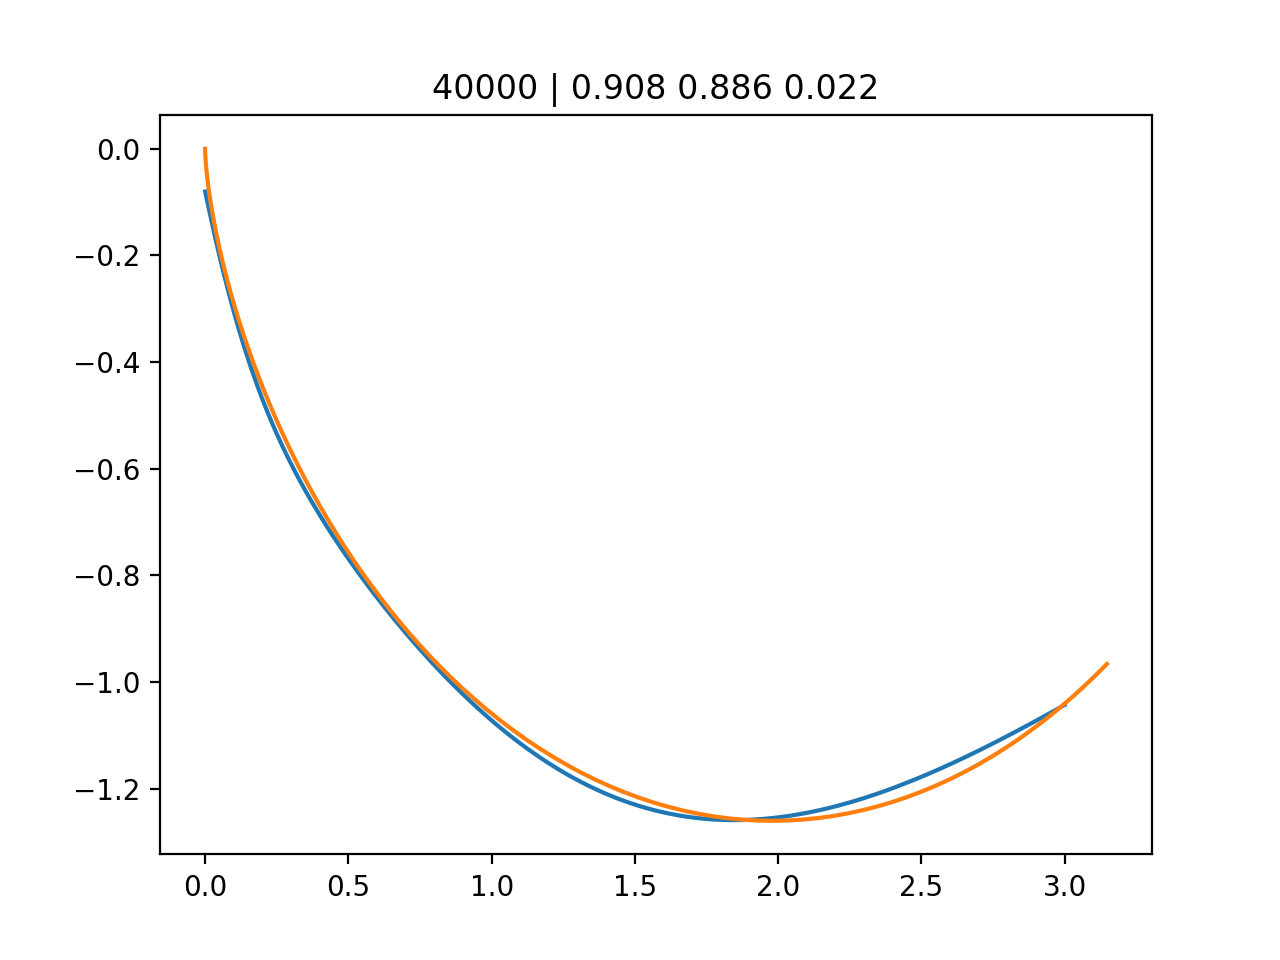

CPU times: user 3min 25s, sys: 24.8 s, total: 3min 50s
Wall time: 2min 16s


In [5]:
%%time
test(n_iters=4*10**4)